In [1]:
%matplotlib inline
%run utils.ipynb

NameError: name 'azfit' is not defined

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors, ticker

import pandas as pd
import numpy as np
import scipy as sp
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
import arviz as az
import seaborn as sns

import kinesis as kn
import gapipes as gp

In [3]:
out_full = pd.read_csv("../data/hyades_full.csv")
df = out_full.loc[out_full['in_dr2'] == True].copy()
b0 = np.median(df.g.icrs.cartesian.xyz.value, axis=1)
with np.printoptions(formatter=dict(float=lambda x:'{:7.3f}'.format(x))):
    print(f'b0 = {b0} pc')

def add_cartesian_xv(df):
    df['x'], df['y'], df['z'] = df.g.icrs.cartesian.xyz.value
    df['vx'], df['vy'], df['vz'] = df.g.icrs.velocity.d_xyz.value
    df['gx'], df['gy'], df['gz'] = df.g.galactic.cartesian.xyz.value
    df['gvx'], df['gvy'], df['gvz'] = df.g.galactic.velocity.d_xyz.value
add_cartesian_xv(out_full)
add_cartesian_xv(df)

b0 = [ 17.268  41.643  13.606] pc


In [4]:
fn = '../report/mock-hyades/default/'

In [6]:
def get_data(fn):
    fit = kn.load_stanfit(fn)
    azfit = az.from_pystan(fit)

    v = azfit
    for ck, cv in kn.decompose_T(v.posterior['T_param']).items():
        v.posterior[ck]=cv
    sigv_samples, Omega_samples = v.posterior['sigv'],  v.posterior['Omega']
    Sigma_samples = np.einsum('cni,cnij,cnj->cnij', sigv_samples, Omega_samples, sigv_samples)
    v.posterior['Sigma'] = ('chain','draw','Simga_dim_0','Sigma_dim_1'), Sigma_samples
    v.posterior['Sigma_gal'] = ('chain','draw','Simga_dim_0','Sigma_dim_1'), kn.rotate_T_to_galactic(Sigma_samples)
    v.posterior['T_param_gal'] = ('chain','draw','dim0','dim1'), kn.rotate_T_to_galactic(v.posterior['T_param'])
    for ck, cv in kn.decompose_T(v.posterior['T_param_gal']).items():
        v.posterior[ck+'_gal']  = cv
    return azfit
fits = {'fit{}'.format(i):get_data('../report/mock-hyades/default/fit{}.pickle'.format(i)) for i in range(1, 6)}

## Table of summary statistics

In [6]:
from IPython.display import display, HTML
var_names = list(azfit.posterior.data_vars.keys())
for c in ['probmem','a_model','rv_model']:
    if c in var_names:
        var_names.remove(c)
with pd.option_context("display.max_rows", 100):
    display(HTML(az.summary(azfit, var_names).to_html()))

/data/vault/soh/projects/opensource/arviz/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.316,0.020,-6.352,-6.279,0.000,0.000,1613.0,1613.0,1610.0,2395.0,1.0
v0[1],45.241,0.033,45.175,45.298,0.001,0.001,1651.0,1651.0,1659.0,1876.0,1.0
v0[2],5.315,0.017,5.283,5.347,0.000,0.000,2007.0,2007.0,2009.0,2673.0,1.0
sigv[0],0.301,0.023,0.258,0.345,0.001,0.000,1206.0,1206.0,1247.0,1576.0,1.0
sigv[1],0.184,0.062,0.065,0.299,0.002,0.001,889.0,889.0,901.0,731.0,1.0
sigv[2],0.309,0.021,0.271,0.346,0.001,0.000,1339.0,1339.0,1369.0,1735.0,1.0
"Omega[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"Omega[0,1]",0.244,0.260,-0.255,0.733,0.008,0.005,1197.0,1197.0,1201.0,1732.0,1.0
"Omega[0,2]",0.201,0.094,0.023,0.366,0.003,0.002,1061.0,1061.0,1142.0,1512.0,1.0
"Omega[1,0]",0.244,0.260,-0.255,0.733,0.008,0.005,1197.0,1197.0,1201.0,1732.0,1.0


In [62]:
param_true = dict(
    b0=[17.7, 41.2, 13.3], v0=np.array([-6.32, 45.24, 5.30]), sigmav=0.3
)

## Mean velocity

In [103]:
dfs = [
    az.summary(v, var_names=["v0"])
    .assign(repeat=k)
    .set_index('repeat', append=True,)
    for k, v in fits.items()
]
s = pd.concat(dfs)
lerr=s['mean']-s['hpd_3%']
uerr=s['hpd_97%']-s['mean']

INFO:numexpr.utils:Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


[         mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
 v0[0]  -6.320  0.021  -6.359   -6.283      0.000    0.000    1714.0  1714.0   
 v0[1]  45.201  0.035  45.134   45.267      0.001    0.001    1874.0  1874.0   
 v0[2]   5.298  0.017   5.265    5.330      0.000    0.000    2083.0  2083.0   
 
        ess_bulk  ess_tail  r_hat repeat  
 v0[0]    1717.0    2157.0    1.0   fit1  
 v0[1]    1873.0    2377.0    1.0   fit1  
 v0[2]    2083.0    2729.0    1.0   fit1  ,
          mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
 v0[0]  -6.328  0.021  -6.369   -6.287      0.001    0.000    1618.0  1618.0   
 v0[1]  45.225  0.037  45.152   45.293      0.001    0.001    1369.0  1369.0   
 v0[2]   5.293  0.018   5.259    5.326      0.000    0.000    1746.0  1745.0   
 
        ess_bulk  ess_tail  r_hat repeat  
 v0[0]    1619.0    2190.0    1.0   fit2  
 v0[1]    1377.0    1947.0    1.0   fit2  
 v0[2]    1764.0    2693.0    1.0   fit2  ,
          

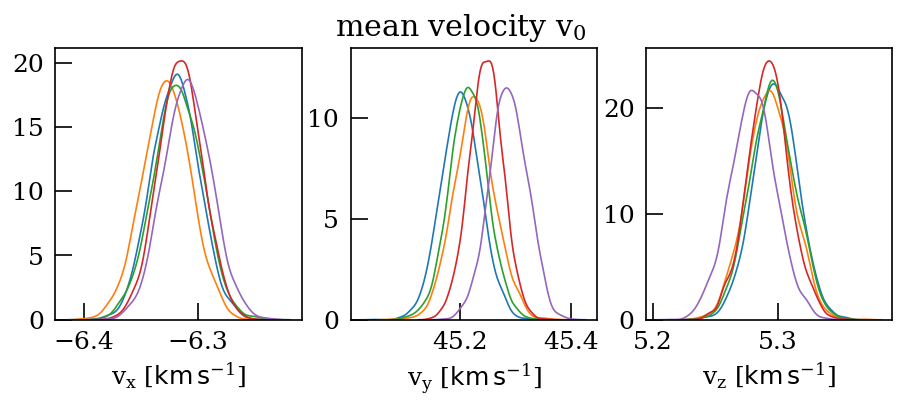

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for k,v in fits.items():
    for i, cax in enumerate(ax):
        sns.kdeplot(
            v.posterior["v0"].stack(samples=["chain", "draw"])[i],
            ax=cax, lw=1,
            legend=False,
        )
ax[0].set_xlabel("$v_x$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[1].set_xlabel("$v_y$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[2].set_xlabel("$v_z$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
fig.suptitle('mean velocity $v_0$');

## Velocity dispersion

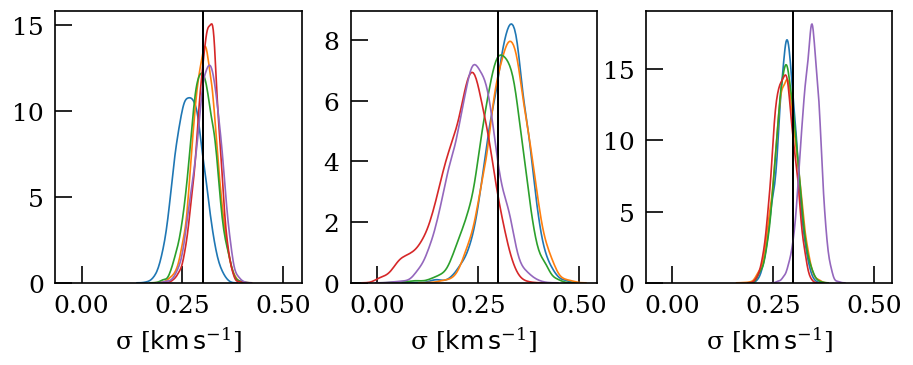

In [61]:
fig, ax = plt.subplots(1, 3, figsize=(9,3), sharex=True)
for k, v in fits.items():
    for i, axis in zip(range(3), ['x','y','z']):
        cax = ax[i]
        sns.kdeplot(
            v.posterior["sigv"].stack(samples=["chain", "draw"])[i],
            ax=cax,
            label='${}$'.format(axis),
            legend=False,lw=1
        )
        cax.set_xlabel("$\sigma$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
        cax.axvline(0.3, c='k', lw=1)
# ax.legend();
# ax.set_title('velocity dispersion scale');

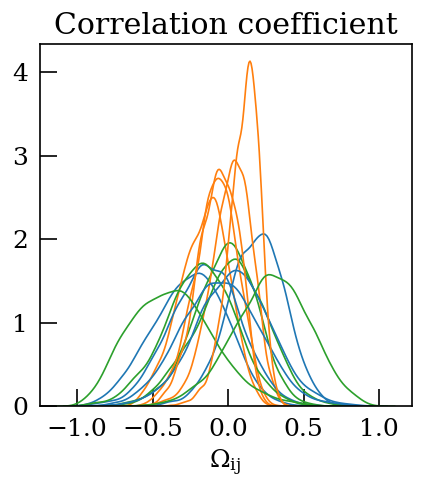

In [60]:
fig, ax = plt.subplots(figsize=(4,4))
for k, azfit in fits.items():
    Omega_offdiag = (
        azfit.posterior["Omega"].stack(i=["chain", "draw"]).values[[0, 0, 1], [1, 2, 2], :]
    )
    for val, label, color in zip(Omega_offdiag, ["01", "02", "12"], ['C0','C1','C2']):
        sns.kdeplot(val, label=label, ax=ax, color=color, lw=1, legend=False)
ax.set_xlabel('$\Omega_{ij}$')
ax.set_title('Correlation coefficient');
ax.set_xticks([-1,-0.5,0,0.5,1]);
# ax.legend(title='$ij$');

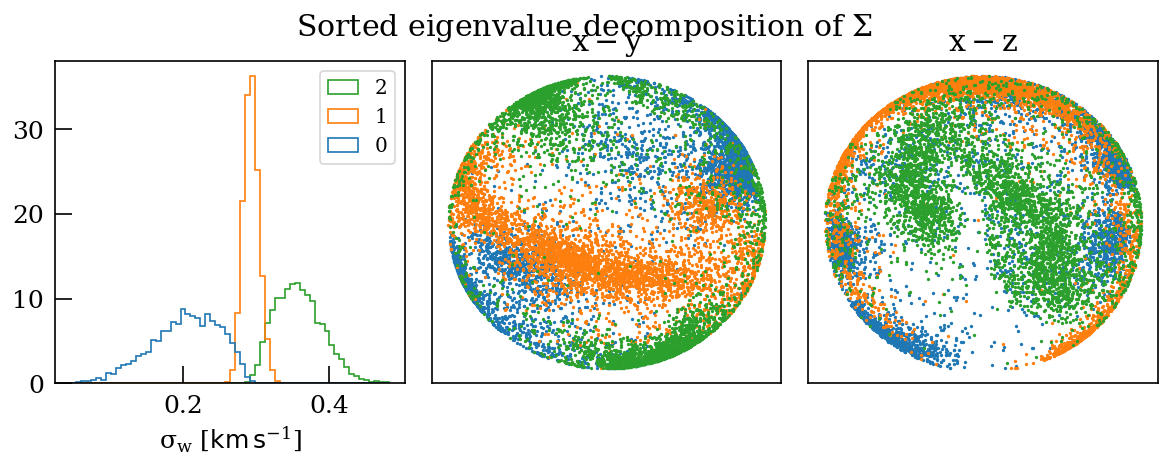

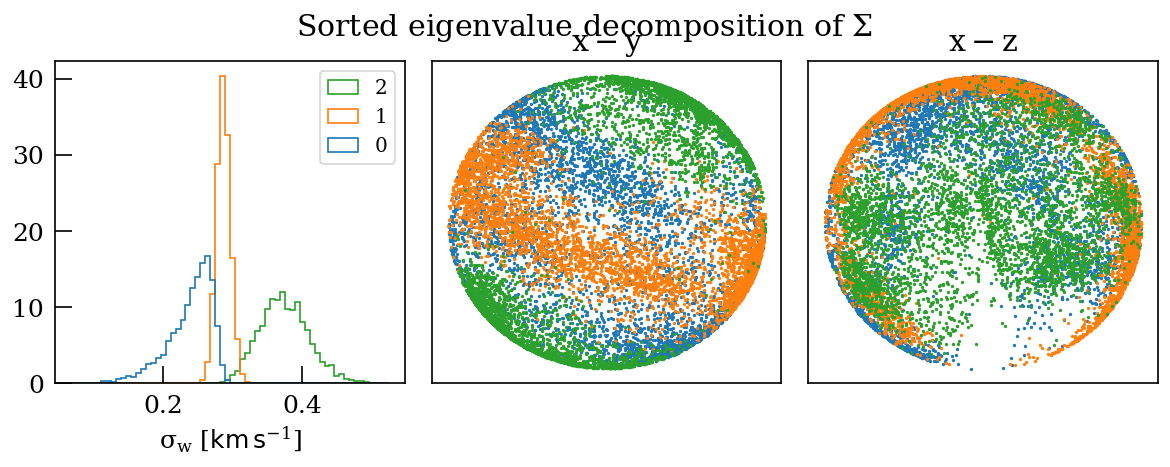

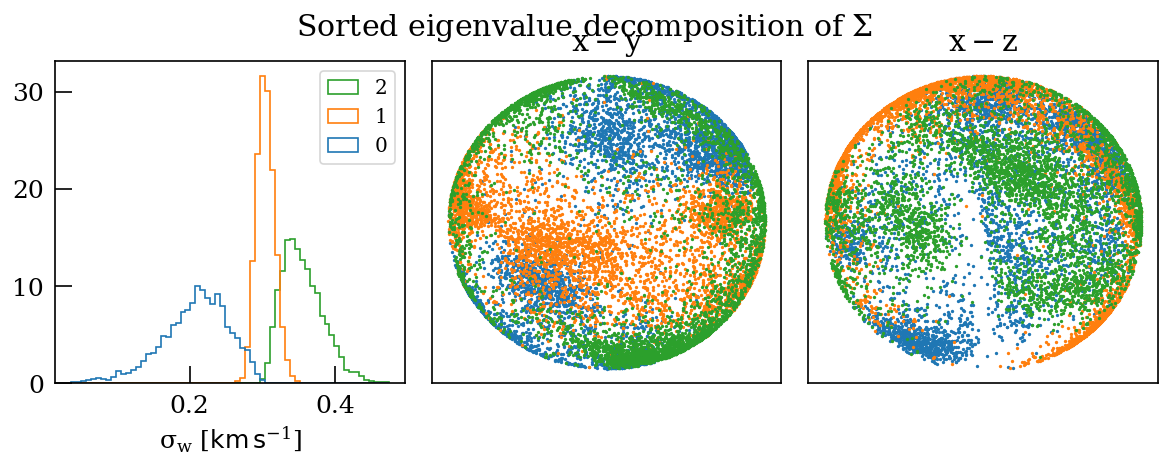

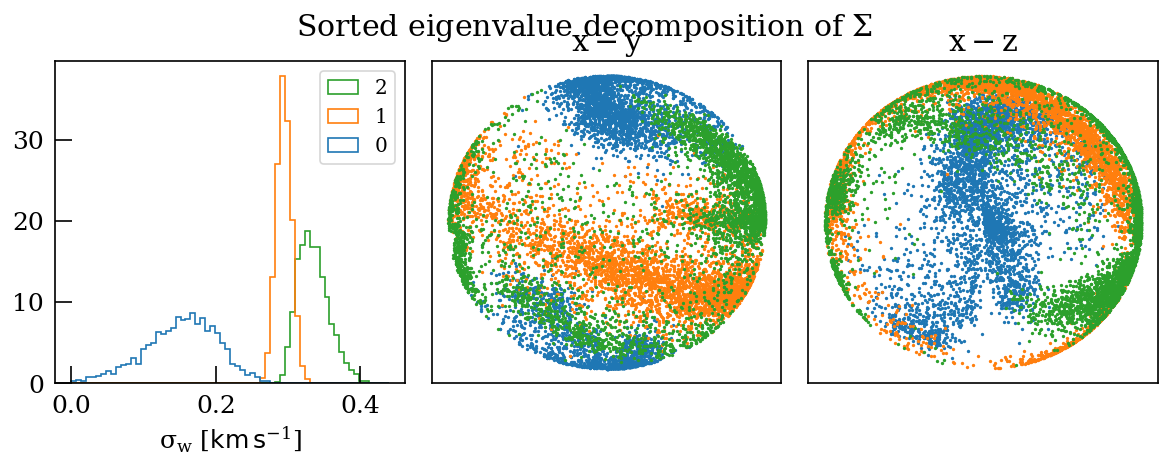

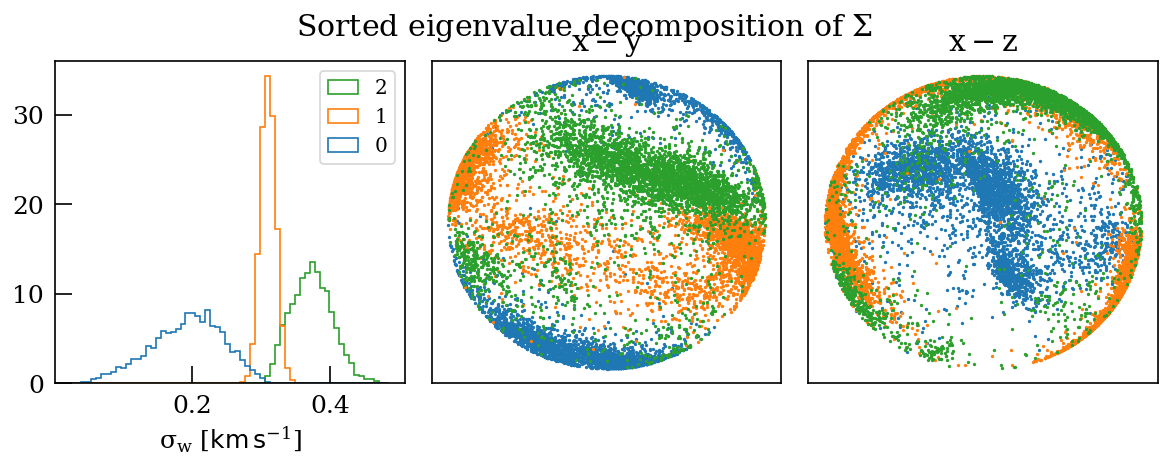

In [120]:
for k, azfit in fits.items():
    eig = kn.EigenvalueDecomposition(
        azfit.posterior['Sigma'].stack(samples=['chain','draw']).T)

    fig, ax = plt.subplots(1, 3, figsize=(10,4))
    ax[0].hist(np.sqrt(eig.w), density=True, bins=64, histtype='step', label=['0','1','2']);
    for i in range(3):
        ax[1].scatter(eig.v[:,0,i], eig.v[:,1,i],s=1);
        ax[2].scatter(eig.v[:,0,i], eig.v[:,2,i],s=1);
    fig.suptitle("Sorted eigenvalue decomposition of $\Sigma$")
    ax[0].set_xlabel("$\sigma_w$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
    def cleanticks(cax):
        cax.set_xticks([])
        cax.set_yticks([])
    cleanticks(ax[1])
    cleanticks(ax[2])
    ax[1].set_title('$x-y$')
    ax[2].set_title('$x-z$');
    ax[0].legend()
    fig.tight_layout()

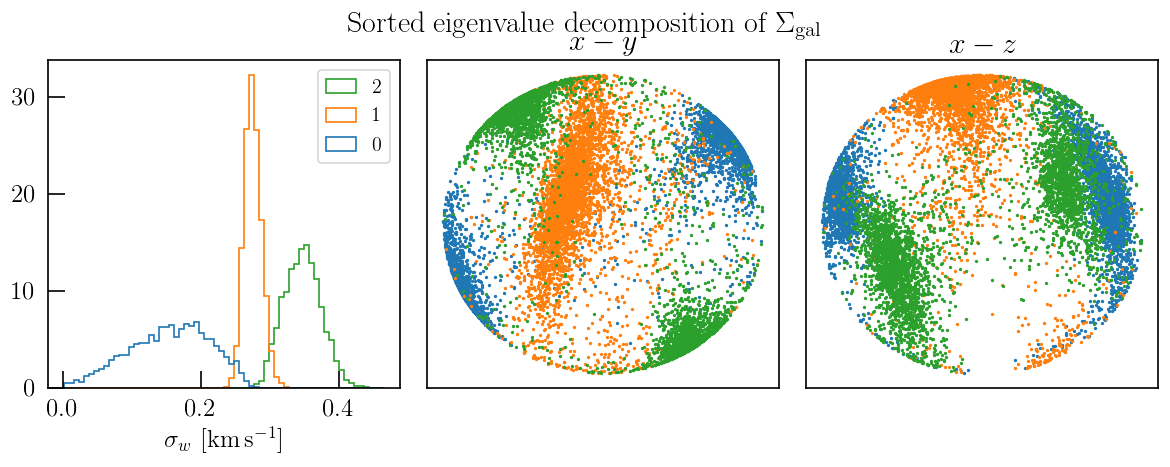

In [10]:
eig = kn.EigenvalueDecomposition(
    azfit.posterior['Sigma_gal'].stack(samples=['chain','draw']).T)

fig, ax = plt.subplots(1, 3, figsize=(10,4))
ax[0].hist(np.sqrt(eig.w), density=True, bins=64, histtype='step', label=['0','1','2']);
for i in range(3):
    ax[1].scatter(eig.v[:,0,i], eig.v[:,1,i],s=1);
    ax[2].scatter(eig.v[:,0,i], eig.v[:,2,i],s=1);
fig.suptitle("Sorted eigenvalue decomposition of $\Sigma_\mathrm{gal}$")
ax[0].set_xlabel("$\sigma_w$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
def cleanticks(cax):
    cax.set_xticks([])
    cax.set_yticks([])
cleanticks(ax[1])
cleanticks(ax[2])
ax[1].set_title('$x-y$')
ax[2].set_title('$x-z$');
ax[0].legend()
fig.tight_layout()

eigval mean = [  +0.154   +0.276   +0.348]
eigval std  = [  +0.058   +0.013   +0.027]


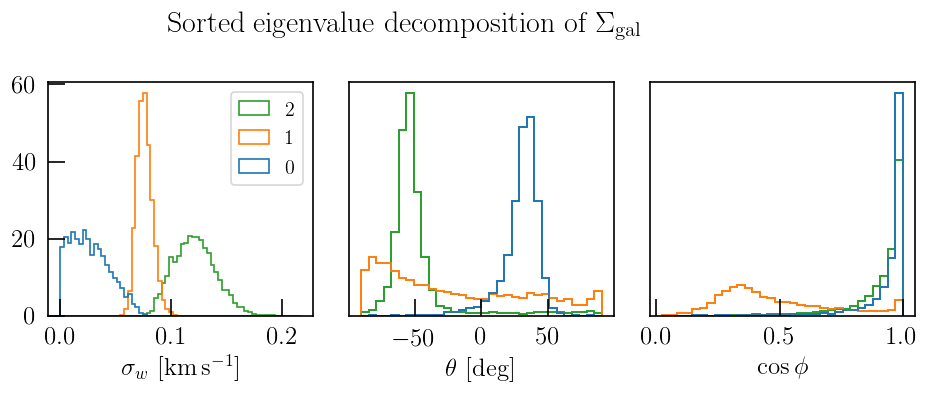

In [11]:
def cleanyticks(cax):
    cax.set_yticks([])

eig = kn.EigenvalueDecomposition(
    azfit.posterior['Sigma_gal'].stack(samples=['chain','draw']).T)
with np.printoptions(formatter=dict(float=lambda x:'{:+8.3f}'.format(x))):
    print('eigval mean = {}'.format(np.sqrt(eig.w).mean(axis=0), precision=3))
    print('eigval std  = {}'.format(np.sqrt(eig.w).std(axis=0), precision=3))

fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].hist(eig.w, density=True, bins=64, histtype="step", label=["0", "1", "2"])
for i in range(3):
    ax[1].hist(
        eig.theta, histtype="step", density=True, bins=32, color=["C0", "C1", "C2"]
    )
    ax[2].hist(
        eig.cosphi, histtype="step", density=True, bins=32, color=["C0", "C1", "C2"]
    )
fig.suptitle("Sorted eigenvalue decomposition of $\Sigma_\mathrm{gal}$")
ax[0].set_xlabel("$\sigma_w$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
cleanyticks(ax[1])
cleanyticks(ax[2])
ax[1].set_xlabel(r"$\theta$ [deg]")
ax[2].set_xlabel("$\cos\phi$")

ax[0].legend()
fig.tight_layout(rect=[0.15, 0.15, 0.95, 0.9])

## Linear velocity field

In [13]:
plt.rc('text', usetex=False)

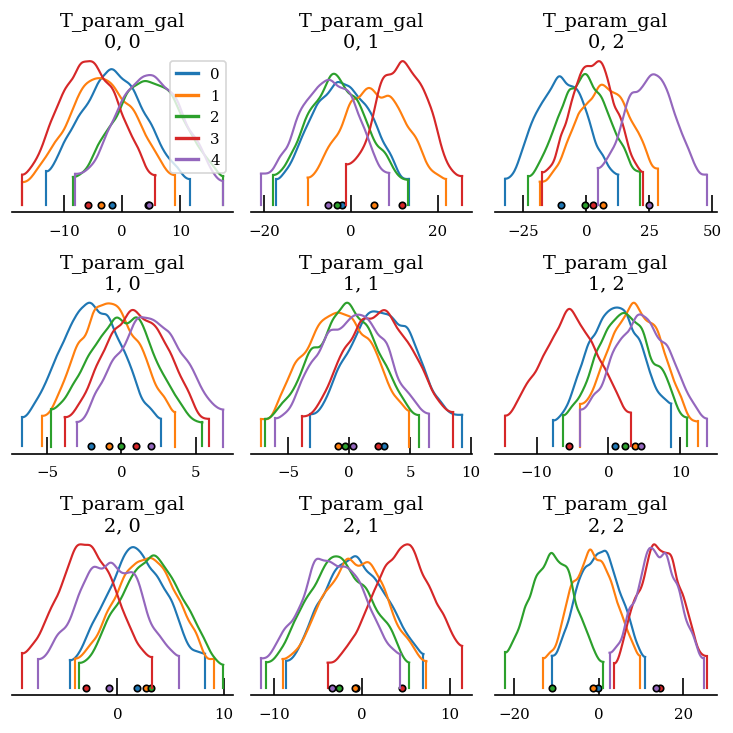

In [32]:
az.plot_density([v for k,v in fits.items()], var_names='T_param_gal', figsize=(6,6), textsize=9);

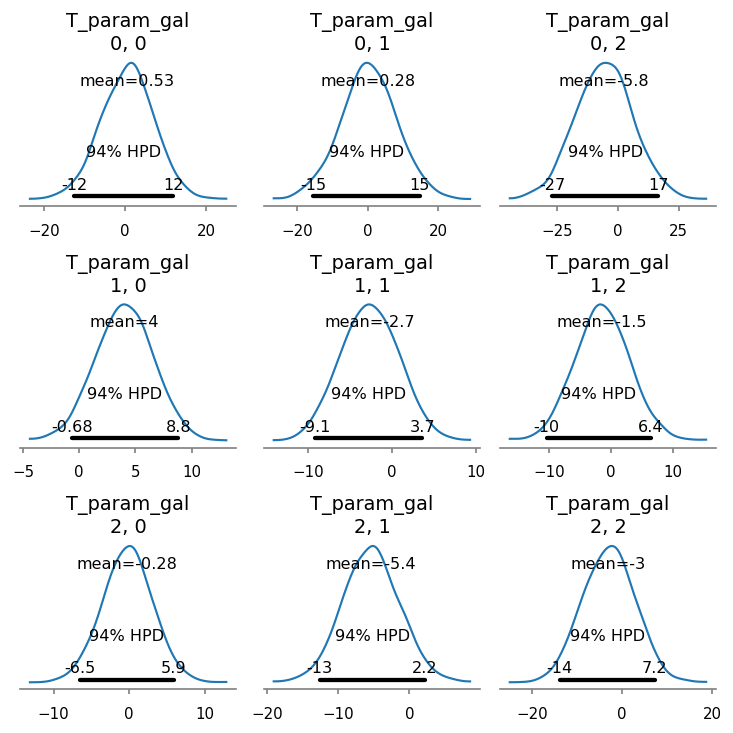

In [14]:
az.plot_posterior(azfit, 'T_param_gal', figsize=(6,6), textsize=9);

In [15]:
probmem_mean = fit["probmem"].mean(axis=0)
members = probmem_mean > 0.5
grp = cdf.groupby(members)

In [25]:
d = grp.get_group(True)

In [23]:
cc = coord.ICRS(*(b0*u.pc), *(fit['v0'].mean(axis=0)*u.km/u.s),
                representation_type='cartesian', differential_type='cartesian')
ccg = cc.transform_to(coord.Galactic)
v0_g = ccg.velocity.d_xyz.value
b0_g = ccg.cartesian.xyz.value

INFO:numexpr.utils:Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


(-2, 2)

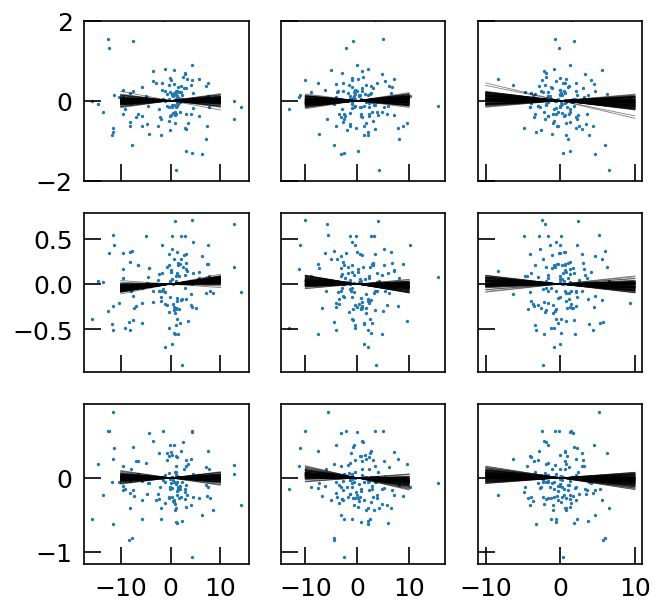

In [26]:
fig, ax = plt.subplots(3,3, figsize=(6,6), sharex='col', sharey='row')
i_random = np.random.randint(0, 4000, 100)
# ax[0,0].scatter(d['gx'],d['gvx'], s=1)
# ax[0,1].scatter(d['gy'],d['gvx'], s=1)
# ax[0,2].scatter(d['gz'],d['gvx'], s=1)
T = azfit.posterior['T_param_gal'].stack(i=['chain','draw']).values
xs=np.linspace(-10,10,101)
v0=fit['v0'].mean(axis=0)

for i_row, ylabel in zip([0,1,2], ['gvx','gvy','gvz']):
    for i_col, xlabel in zip([0,1,2], ['gx','gy','gz']):
        ax[i_row,i_col].scatter(d[xlabel]-b0_g[i_col],d[ylabel]-v0_g[i_row],s=1)
        for i in i_random:
            ax[i_row,i_col].plot(xs, T[i_row,i_col,i]/1e3*(xs), lw=.5, color='k',alpha=.5)
ax[0,0].set_ylim(-2,2)

### Rotation

omega =   +8.967 +-    4.342
omega =   +8.656 +-    3.621
omega =   +7.976 +-    3.600
omega =   +9.997 +-    3.728
omega =  +15.168 +-    5.233


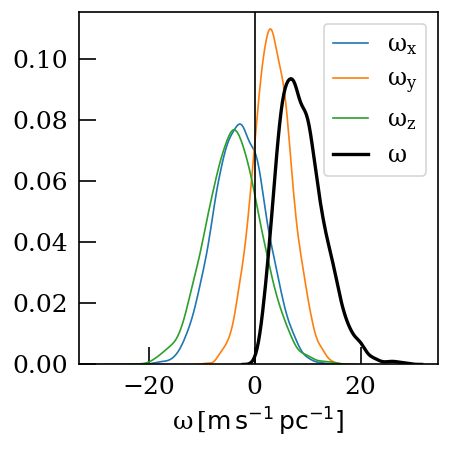

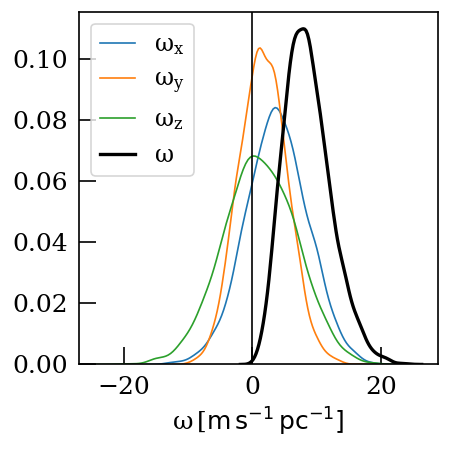

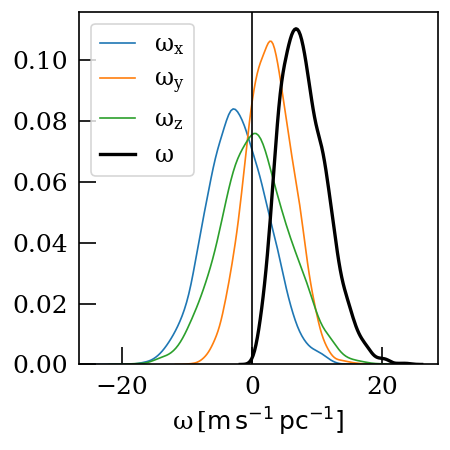

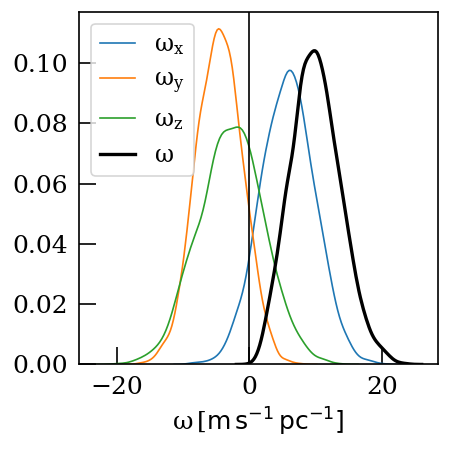

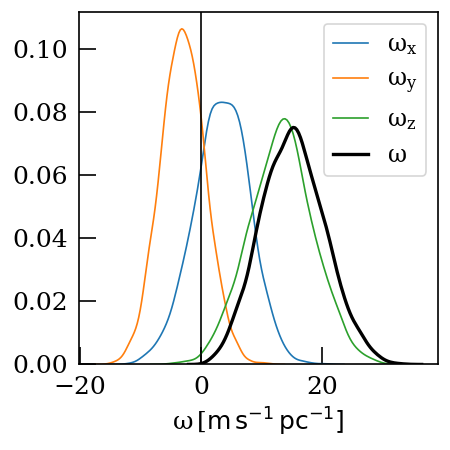

In [33]:
for k, azfit in fits.items():
    wT = azfit.posterior.stack(i=['chain','draw'])
    fig, ax = plt.subplots(figsize=(4,4))
    sns.distplot(wT["omegax"], hist=False, kde_kws={'lw':1}, label=r'$\omega_x$')
    sns.distplot(wT["omegay"], hist=False, kde_kws={'lw':1}, label=r'$\omega_y$')
    sns.distplot(wT["omegaz"], hist=False, kde_kws={'lw':1}, label=r'$\omega_z$')
    omega = np.sqrt(wT["omegax"] ** 2 + wT["omegay"] ** 2 + wT["omegaz"] ** 2)
    print(f"omega = {np.mean(omega.values):+8.3f} +- {np.std(omega.values):8.3f}")
    sns.distplot(omega, hist=False, color='k', label=r'$\omega$')
    ax.axvline(0, c='k', lw=1)
    ax.legend(fontsize=14)
    ax.set_xlabel(r'$\omega\,[\rm m\,\rm s^{-1}\,\rm pc^{-1}]$');
    fig.tight_layout()

### Shear

eigval mean = [ -10.327   +1.749   +9.578]
eigval std  = [  +6.800   +3.212   +4.207]
eigval mean = [ -12.364   -2.412   +8.834]
eigval std  = [  +5.212   +3.479   +6.412]
eigval mean = [ -14.572   -2.041   +9.538]
eigval std  = [  +5.658   +3.531   +6.179]
eigval mean = [ -11.253   +5.085  +17.207]
eigval std  = [  +5.684   +3.693   +5.278]
eigval mean = [  -7.290   +1.954  +23.793]
eigval std  = [  +4.471   +3.469   +8.678]


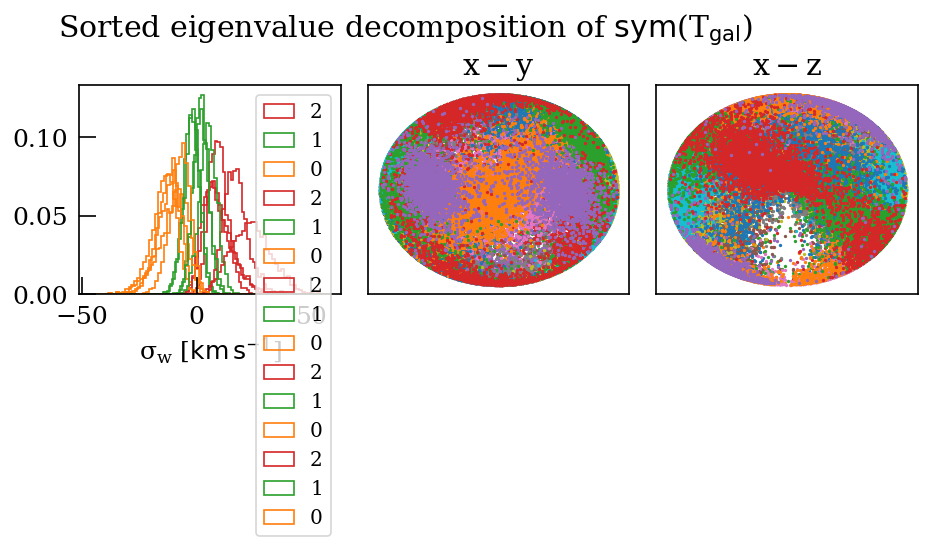

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(10,4))
for k, azfit in fits.items():
    T_galactic = kn.rotate_T_to_galactic(azfit.posterior['T_param'].stack(i=['chain','draw']).transpose('i','T_param_dim_0','T_param_dim_1').values)
    T_sym = (T_galactic + np.transpose(T_galactic, (0, 2, 1))) / 2.


    eig = kn.EigenvalueDecomposition(T_sym)
    with np.printoptions(formatter=dict(float=lambda x:'{:+8.3f}'.format(x))):
        print('eigval mean = {}'.format(eig.w.mean(axis=0), precision=3))
        print('eigval std  = {}'.format(eig.w.std(axis=0), precision=3))


    ax[0].hist(eig.w, density=True, bins=64, histtype='step', label=['0','1','2'], color=['C1','C2','C3']);
    for i in range(3):
        ax[1].scatter(eig.v[:,0,i], eig.v[:,1,i],s=1);
        ax[2].scatter(eig.v[:,0,i], eig.v[:,2,i],s=1);
fig.suptitle(r"Sorted eigenvalue decomposition of $\mathrm{sym}(T_{\rm gal})$")
ax[0].set_xlabel("$\sigma_w$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
def cleanticks(cax):
    cax.set_xticks([])
    cax.set_yticks([])
cleanticks(ax[1])
cleanticks(ax[2])
ax[1].set_title('$x-y$')
ax[2].set_title('$x-z$');
ax[0].legend()
fig.tight_layout(rect=[0.15,0.15,0.95,0.95])

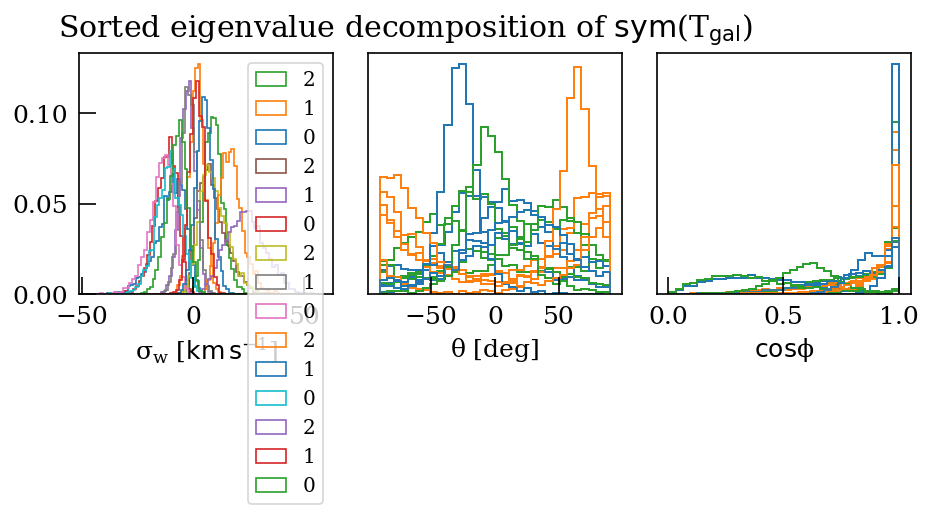

In [49]:
def cleanyticks(cax):
    cax.set_yticks([])
fig, ax = plt.subplots(1, 3, figsize=(10, 4))

for k, azfit in fits.items():
    T_galactic = kn.rotate_T_to_galactic(azfit.posterior['T_param'].stack(i=['chain','draw']).transpose('i','T_param_dim_0','T_param_dim_1').values)
    T_sym = (T_galactic + np.transpose(T_galactic, (0, 2, 1))) / 2.0
    eig = kn.EigenvalueDecomposition(T_sym)



    ax[0].hist(eig.w, density=True, bins=64, histtype="step", label=["0", "1", "2"])
    for i in range(3):
        ax[1].hist(
            eig.theta, histtype="step", density=True, bins=32, color=["C0", "C1", "C2"]
        )
        ax[2].hist(
            eig.cosphi, histtype="step", density=True, bins=32, color=["C0", "C1", "C2"]
        )
fig.suptitle(r"Sorted eigenvalue decomposition of $\mathrm{sym}(T_{\rm gal})$")
ax[0].set_xlabel("$\sigma_w$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
cleanyticks(ax[1])
cleanyticks(ax[2])
ax[1].set_xlabel(r"$\theta$ [deg]")
ax[2].set_xlabel("$\cos\phi$")

ax[0].legend()
fig.tight_layout(rect=[0.15, 0.15, 0.95, 0.95])

eigval mean = [ -23.689   +2.422  +24.944]
eigval std  = [  +8.468   +4.238   +8.607]


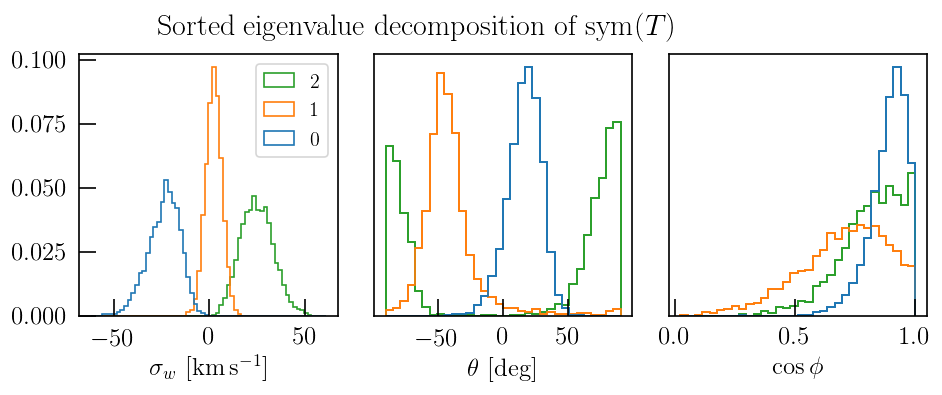

In [18]:
def cleanyticks(cax):
    cax.set_yticks([])

T_galactic = fit["T_param"]
T_sym = (T_galactic + np.transpose(T_galactic, (0, 2, 1))) / 2.
eig = kn.EigenvalueDecomposition(T_sym)
with np.printoptions(formatter=dict(float=lambda x:'{:+8.3f}'.format(x))):
    print('eigval mean = {}'.format(eig.w.mean(axis=0), precision=3))
    print('eigval std  = {}'.format(eig.w.std(axis=0), precision=3))

fig, ax = plt.subplots(1, 3, figsize=(10,4))
ax[0].hist(eig.w, density=True, bins=64, histtype='step', label=['0','1','2']);
for i in range(3):
    ax[1].hist(eig.theta, histtype='step', density=True, bins=32, color=['C0','C1','C2'])
    ax[2].hist(eig.cosphi, histtype='step', density=True, bins=32, color=['C0','C1','C2'])
fig.suptitle("Sorted eigenvalue decomposition of $\mathrm{sym}(T)$")
ax[0].set_xlabel("$\sigma_w$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
cleanyticks(ax[1])
cleanyticks(ax[2])
ax[1].set_xlabel(r'$\theta$ [deg]')
ax[2].set_xlabel('$\cos\phi$')

ax[0].legend()
fig.tight_layout(rect=[0.15,0.15,0.95,0.95])

## Membership

In [19]:
cdf = pd.DataFrame({'ra':fit.data['ra'], 'dec':fit.data['dec']})
cdf['parallax'], cdf['pmra'], cdf['pmdec'] = fit.data['a'].T
cdf.loc[fit.data['irv'], 'radial_velocity'] = fit.data['rv']
add_cartesian_xv(cdf)

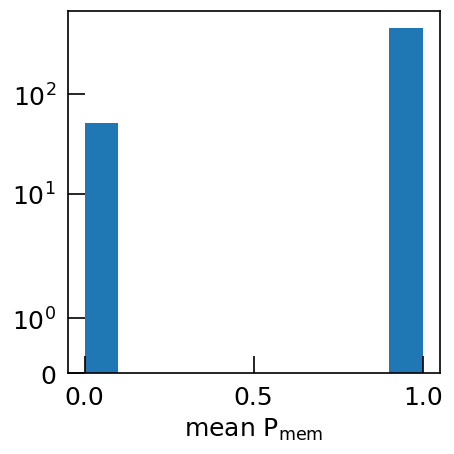

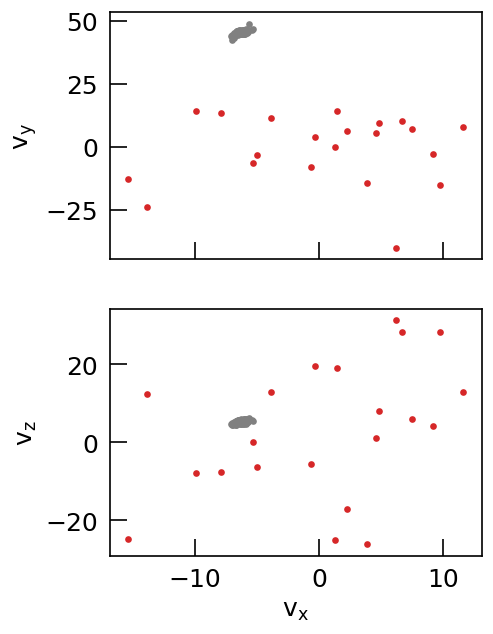

In [22]:
from matplotlib.gridspec import GridSpec

probmem_mean = np.exp(fit["probmem"]).mean(axis=0)
members = probmem_mean > 0.5
grp = cdf.groupby(members)

fig, ax = plt.subplots()
ax.hist(probmem_mean)
ax.set_yscale("symlog")
ax.set_xlabel(r"mean $P_{\rm mem}$")

with plt.rc_context(rc={"axes.prop_cycle": plt.cycler(color=["tab:red", "gray"])}):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6), sharex=True)
    # gs = GridSpec(4, 1)
    # ax1 = fig.add_subplot(gs[:3])
    # ax2 = fig.add_subplot(gs[3], sharex=ax1)
    for label, g in grp:
        ax1.scatter(g["vx"], g["vy"], s=9)
        ax2.scatter(g["vx"], g["vz"], s=9)
    ax2.set_xlabel(r'$v_x$')
    ax2.set_ylabel(r'$v_z$')
    ax1.set_ylabel(r'$v_y$')

In [21]:
cc = coord.ICRS(*(b0*u.pc), *(fit['v0'].mean(axis=0)*u.km/u.s),
                representation_type='cartesian', differential_type='cartesian')
ccg = cc.transform_to(coord.Galactic)
vx,vy,vz = ccg.velocity.d_xyz.value

In [47]:
# fig, ax = plt.subplots()
# g = grp.get_group(True)    # remove outliers
# ax.scatter(g["gx"]-ccg.cartesian.x.value, g["gvx"]-vx, s=9)
# ax.scatter(g["gy"]-ccg.cartesian.y.value, g["gvy"]-vy, s=9)
#     ax.scatter(g["gx"], g["gvz"]-vz, s=9)